In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from pathlib import Path
import sys

# Model-1(check): Time-Resolved Velocity Model
- Note: Cutting the time of drive cycles from 300 to 800 seconds to predict the SOC_drop at 800 second

In [2]:
sys.path.append(str(Path().resolve().parent.parent))
from path_manager import VEL_MODELS, MISC_DIR, VEL_DATA_DIR, PLOT_DIR

In [3]:
velocity_soc_df = pd.read_csv(MISC_DIR / 'velocity_relative_SOC.csv')
test_df = pd.read_csv(MISC_DIR / 'velocity_relative_SOC_test_new.csv')
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
VEL_TRAIN_A1 = VEL_DATA_DIR / 'train' / 'assertive_batch1'
VEL_TRAIN_A2 = VEL_DATA_DIR / 'train' / 'assertive_batch2'
VEL_TRAIN_D1 = VEL_DATA_DIR / 'train' / 'defensive_batch1'
VEL_TRAIN_D2 = VEL_DATA_DIR / 'train' / 'defensive_batch2'

VEL_REF = VEL_DATA_DIR / 'reference'
VEL_TEST = VEL_DATA_DIR / 'test'

In [5]:
vel_def_11= pd.read_excel(VEL_TRAIN_D1 / 'speed_DR_75188.xlsx')
vel_def_12= pd.read_excel(VEL_TRAIN_D1 /'speed_DR_75053.xlsx')
vel_def_13= pd.read_excel(VEL_TRAIN_D1 / 'speed_DR_74866.xlsx')
vel_def_14= pd.read_excel(VEL_TRAIN_D1 / 'speed_DR_74789.xlsx')
vel_def_21= pd.read_excel(VEL_TRAIN_D2 / 'speed_DR_4716.xlsx')

# switch with
vel_def_22 = pd.read_excel(VEL_TRAIN_D2 / 'speed_DR_74705.xlsx')
#vel_def_22= pd.read_excel(r'drivecycles/def2/speed_DR_4832.xlsx')

vel_def_23= pd.read_excel(VEL_TRAIN_D2 / 'speed_DR_4839.xlsx')
vel_def_24= pd.read_excel(VEL_TRAIN_D2 / 'speed_DR_4840.xlsx')

# outer
#vel_asser_11 = pd.read_excel(r'drivecycles/asser1/speed_DR_74428.xlsx')
vel_asser_11= pd.read_excel(VEL_TRAIN_A1 / 'speed_DR_14634.xlsx')

# new drive cycle
# vel_asser_11= pd.read_excel(r'drivecycles/asser1/speed_DR_14634.xlsx')

vel_asser_12= pd.read_excel(VEL_TRAIN_A1 / 'speed_DR_74517.xlsx')
vel_asser_13= pd.read_excel(VEL_TRAIN_A1 / 'speed_DR_74594.xlsx')
vel_asser_14= pd.read_excel(VEL_TRAIN_A1 / 'speed_DR_74670.xlsx')
vel_asser_21= pd.read_excel(VEL_TRAIN_A2 / 'speed_DR_74765.xlsx')

# switch 
vel_asser_22 = pd.read_excel(VEL_TRAIN_A2 / 'speed_DR_4832.xlsx')
#vel_asser_22= pd.read_excel(r'drivecycles/asser2/speed_DR_74705.xlsx')

vel_asser_23= pd.read_excel(VEL_TRAIN_A2 / 'speed_DR_74674.xlsx')
vel_asser_24= pd.read_excel(VEL_TRAIN_A2 / 'speed_DR_74389.xlsx')

In [6]:
# Inputting the test drive cycles
test_def_11 = pd.read_excel(VEL_TEST / 'test_1_def.xlsx')
test_asser_11 = pd.read_excel(VEL_TEST / 'test_2_asser.xlsx')
test_def_12 = pd.read_excel(VEL_TEST / 'test_3_def.xlsx')
test_asser_12 = pd.read_excel(VEL_TEST / 'test_4_asser.xlsx')

In [7]:
vel_list=[]
vel_list.extend([vel_def_11, vel_def_12, vel_def_13, vel_def_14, 
                 vel_def_11, vel_def_12, vel_def_13, vel_def_14, 
                 vel_def_11, vel_def_12, vel_def_13, vel_def_14,
                 
                 vel_def_21, vel_def_22, vel_def_23, vel_def_24,
                 vel_def_21, vel_def_22, vel_def_23, vel_def_24, 
                 vel_def_21, vel_def_22, vel_def_23, vel_def_24, 
                 
                 vel_asser_11, vel_asser_12, vel_asser_13, vel_asser_14, 
                 vel_asser_11, vel_asser_12, vel_asser_13, vel_asser_14, 
                 vel_asser_11, vel_asser_12, vel_asser_13, vel_asser_14,
                 
                 vel_asser_21, vel_asser_22, vel_asser_23, vel_asser_24, 
                 vel_asser_21, vel_asser_22, vel_asser_23, vel_asser_24, 
                 vel_asser_21, vel_asser_22, vel_asser_23, vel_asser_24,
                 
                 vel_def_11, vel_def_12, vel_def_13, vel_def_14, 
                 vel_def_11, vel_def_12, vel_def_13, vel_def_14, 
                 vel_def_11, vel_def_12, vel_def_13, vel_def_14,
                 
                 vel_def_21, vel_def_22, vel_def_23, vel_def_24,
                 vel_def_21, vel_def_22, vel_def_23, vel_def_24, 
                 vel_def_21, vel_def_22, vel_def_23, vel_def_24,
                 
                 vel_asser_11, vel_asser_12, vel_asser_13, vel_asser_14, 
                 vel_asser_11, vel_asser_12, vel_asser_13, vel_asser_14, 
                 vel_asser_11, vel_asser_12, vel_asser_13, vel_asser_14,
                 
                 vel_asser_21, vel_asser_22, vel_asser_23, vel_asser_24, 
                 vel_asser_21, vel_asser_22, vel_asser_23, vel_asser_24, 
                 vel_asser_21, vel_asser_22, vel_asser_23, vel_asser_24
                ])

In [8]:
# Create a list of the test drive cycles
vel_test = []
vel_test.extend([test_def_11, test_asser_11, test_def_11, 
                 test_asser_11, test_def_11, test_asser_11,
                 test_def_12, test_asser_12, test_def_12,
                 test_asser_12, test_def_12, test_asser_12
])

In [9]:
# Define a function for cutting time-resolved velocity data
def cut_time(timeseries, start_time, end_time):
    return timeseries[(timeseries['time'] >= start_time) & (timeseries['time'] <= end_time)]


# Create the dictionary of DataFrames
vel_dict = {v_d: vel_list[v_d-1] for v_d in range(1, 97)}

# Cutting a portion of velocity from time starts from 300 ~ 800s for early prediction purpose
cut_dict = {}
for key in vel_dict.keys():
    cut_dict[key] = cut_time(vel_dict[key], 300, 800)

In [10]:
# Create the dictionary of DataFrames for the testing dataset
vel_dict_test = {v_d: vel_test[v_d-1] for v_d in range(1, 13)}

# Cutting a portion of velocity from time starts from 300 ~ 800s for early prediction purpose
cut_dict_test = {}
for key in vel_dict_test.keys():
    cut_dict_test[key] = cut_time(vel_dict_test[key], 300, 800)

# Check the first element in cut_dict_test
first_cut_test_element = cut_dict_test[1]
print(first_cut_test_element)

          time      speed
17  312.244898  24.285714
18  330.612245  24.880952
19  348.979592  25.476190
20  367.346939  22.630385
21  385.714286  23.650794
22  404.081633  24.671202
23  422.448980  25.518707
24  440.816327  25.242347
25  459.183673  24.965986
26  477.551020  24.689626
27  495.918367  24.413265
28  514.285714  24.136905
29  532.653061  23.860544
30  551.020408  23.584184
31  569.387755  23.307823
32  587.755102  23.031463
33  606.122449  22.755102
34  624.489796  22.478741
35  642.857143  22.202381
36  661.224490  21.984127
37  679.591837  22.579365
38  697.959184  23.174603
39  716.326531  23.769841
40  734.693878  23.979592
41  753.061224  24.092971
42  771.428571  24.206349
43  789.795918  24.319728


In [11]:
# # Check the first element in cut_dict
# first_cut_element = cut_dict[1]
# print(first_cut_element)

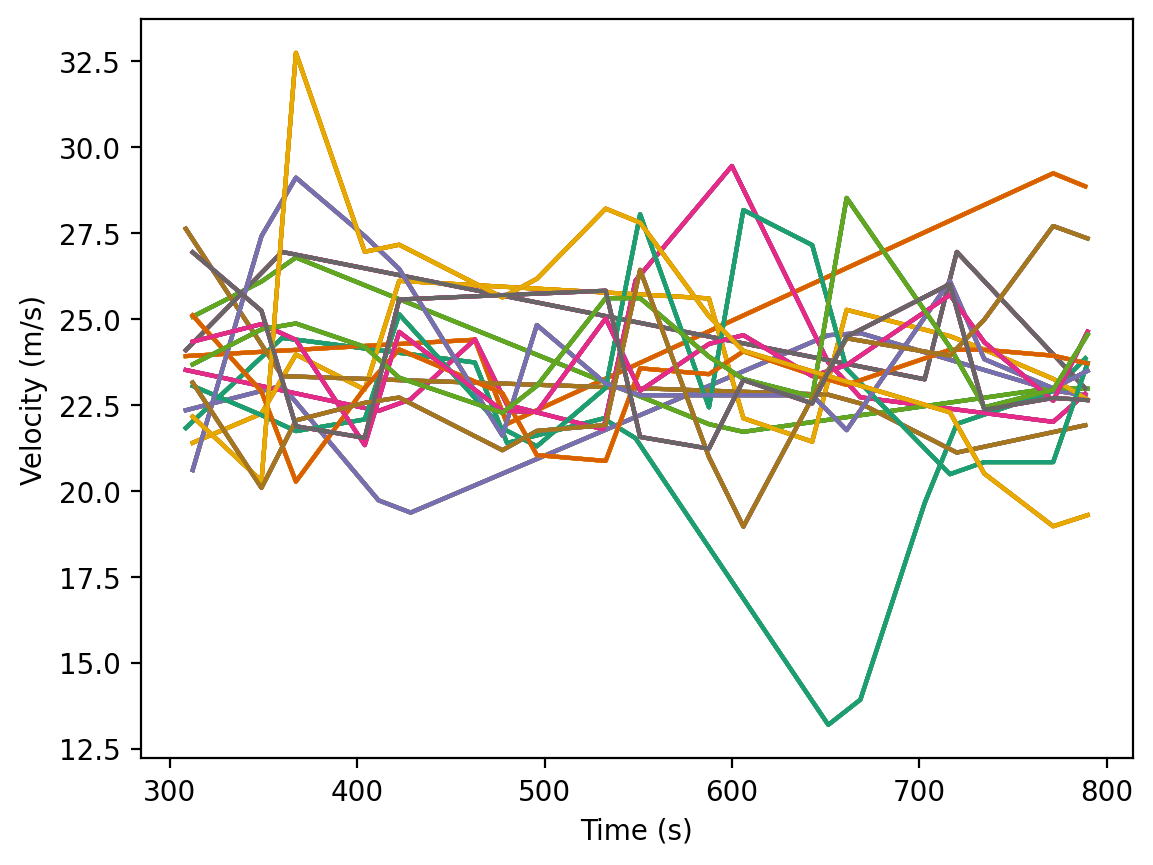

In [14]:
sns.reset_orig()
plt.rcdefaults()
plt.figure()
colors = sns.color_palette("Dark2", 96) 

for i, key in enumerate(cut_dict):
    timeseries = cut_dict[key]
    plt.plot(timeseries["time"], timeseries["speed"], label=f"Cycle {key}", color=colors[i % len(colors)])

plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
# plt.title("Velocity vs. Time for 96 Drive Cycles (Time-resolved)")
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=2, fontsize='small')
# plt.grid(True)
plt.show()

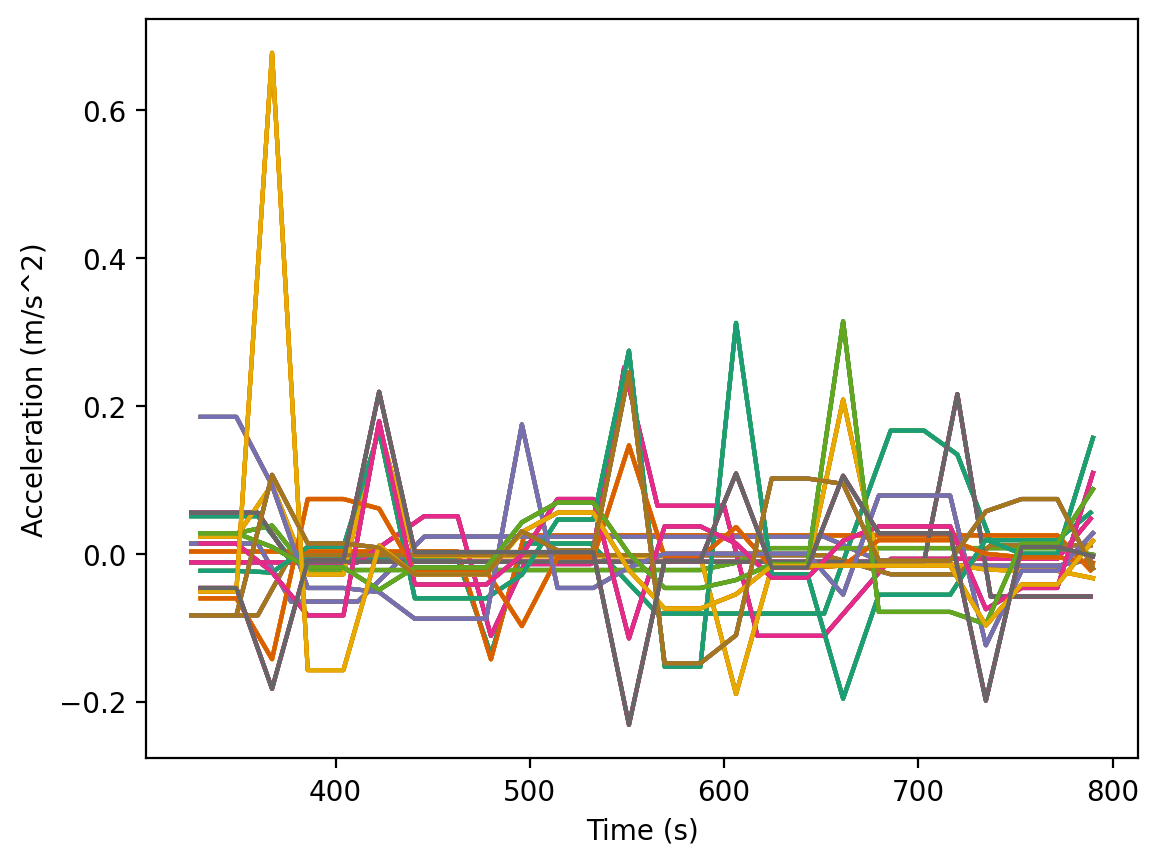

In [15]:
sns.reset_orig()
plt.rcdefaults()
plt.figure()
colors = sns.color_palette("Dark2", 96) 


for i , key in enumerate(cut_dict):
    timeseries = cut_dict[key].copy()  # Ensure that we do not modify the original DataFrame
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    plt.plot(timeseries["time"], timeseries["acceleration"], label=f"Cycle {key}", color = colors[i])

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
# plt.title("Acceleration vs. Time for 96 Drive Cycles (Time-resolved)")
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=2, fontsize='small')
# plt.grid(True)
plt.show()

In [16]:
vel_info= pd.DataFrame({'Mini_trip': range(1, 97)})

# Add the 'Relative_SOC_drop (%)' of a complete drive cycle to evaluate the performance of the ML for the early prediction using time-resolved velocity data.
vel_info['Relative_SOC_drop (%)'] = velocity_soc_df['Relative_SOC_drop (%)']

# Add other features based on the entire trip's classification for early prediction
vel_info['Driver'] = velocity_soc_df['Driver Type']
vel_info['Terrain'] = velocity_soc_df['Terrain']
vel_info['Method'] = velocity_soc_df['Method']

In [17]:
###Testing dataset
vel_info_test = pd.DataFrame({'Mini_trip': range(1, 13)})

vel_info_test['Relative_SOC_drop (%)'] = test_df['Relative_SOC_drop (%)']

In [18]:
vel_info

,Mini_trip,Relative_SOC_drop (%),Driver,Terrain,Method
0,1,62.387902,1,1,1
1,2,79.744542,1,1,1
2,3,70.663244,1,1,1
3,4,74.707409,1,1,1
4,5,59.210020,1,2,1
...,...,...,...,...,...
91,92,78.129824,2,2,2
92,93,85.569316,2,3,2
93,94,80.896135,2,3,2
94,95,80.529824,2,3,2


In [19]:
vel_info_test

,Mini_trip,Relative_SOC_drop (%)
0,1,83.011496
1,2,76.977501
2,3,76.112164
3,4,71.774646
4,5,83.200715
5,6,77.160583
6,7,72.951019
7,8,83.197004
8,9,68.645862
9,10,76.688393


In [20]:
### Feature extraction from the input velocity files

def extract_max_velocity(timeseries):
    max_velocity = timeseries["speed"].max()
    return max_velocity

def extract_mean_velocity(timeseries):
    mean_velocity = timeseries["speed"].mean()
    return mean_velocity

# Higher variability in speed means higher std(standard deviation) often suggests 
# more aggressive or incocnsistent driving patterns, which may lead to higher consumptions
def extract_std_velocity(timeseries):
    std_velocity = timeseries["speed"].std()
    return std_velocity

# Calculate the total distance traveled using the trapezoidal rule for integration
def extract_total_distance(timeseries):
    total_distance = np.trapz(timeseries["speed"], timeseries["time"])
    return total_distance

# Calculate mean, max, min, and standard deviation of acceleration.
def extract_acceleration_metrics(timeseries):
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    mean_acceleration = timeseries['acceleration'].mean()
    max_acceleration = timeseries['acceleration'].max()
    std_acceleration = timeseries['acceleration'].std()
    return mean_acceleration, max_acceleration, std_acceleration

# Calculate the total time spent accelerating > 0.2 m/s^2 
def extract_time_spent_accelerating(timeseries):
    # Calculate acceleration
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    
    # Filter positive accelerations and corresponding time differences
    accelerating_intervals = timeseries['acceleration'] > 0.2
    time_differences = timeseries['time'].diff() #time intervals
    
    # Calculate the total time spent accelerating
    time_spent_accelerating = time_differences[accelerating_intervals].sum() # only sum for value > 0
    return time_spent_accelerating
    
# Calculate the total time spent decelerating < -0.16 m/s^2 
def extract_time_spent_decelerating(timeseries):
    # Calculate acceleration
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    # Filter negative accelerations and corresponding time differences
    decelerating_intervals = timeseries['acceleration'] < -0.16
    time_differences = timeseries['time'].diff() #time intervals
    # Calculate the total time spent decelerating
    time_spent_decelerating = time_differences[decelerating_intervals].sum() # only sum for value < 0
    return time_spent_decelerating

# Extract the maximum deceleration from the timeseries.
def extract_max_deceleration(timeseries):
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    max_deceleration = timeseries['acceleration'].min()
    return max_deceleration

# Extract the mean deceleration from the timeseries.
def extract_mean_deceleration(timeseries):
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    # Filter deceleration values (negative acceleration)
    mean_deceleration = timeseries[timeseries['acceleration'] < 0]['acceleration'].mean() 
    return mean_deceleration

# Function counts the velocity peaks.
def extract_number_of_velocity_peaks(timeseries):
    # Calculate the first difference of velocity
    velocity_diff = timeseries["speed"].diff()

    # Identify positive peaks (speed increases then decreases)
    positive_peaks = (velocity_diff.shift(-1) < 0) & (velocity_diff > 0)
    
    # Identify negative peaks (velocity decreases then increases)
    negative_peaks = (velocity_diff.shift(-1) > 0) & (velocity_diff < 0)
    # Combine both conditions to count all peaks
    all_peaks = positive_peaks | negative_peaks

    number_of_velocity_peaks = all_peaks.sum()
    return number_of_velocity_peaks

# Calculate the average velocity during velocity peaks.
def extract_average_velocity_during_peaks(timeseries):
    peak_velocitys = timeseries["speed"][(timeseries["speed"].diff().shift(-1) < 0) & (timeseries["speed"].diff() > 0)]
    average_velocity_during_peaks = peak_velocitys.mean()
    return average_velocity_during_peaks



# Count the time period for constant velocity
def extract_time_spent_constant_velocity(timeseries):
    # Calculate acceleration
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    
    # Filter intervals with acceleration close to zero and corresponding time differences
    constant_velocity_intervals = timeseries['acceleration'].abs() < 0.01
    time_differences = timeseries['time'].diff()
    
    # Calculate the total time spent at constant velocity
    time_spent_constant_velocity = time_differences[constant_velocity_intervals].sum()
    
    return time_spent_constant_velocity


# Additional time-dependent features
def extract_time_to_max_velocity(timeseries):
    max_velocity_time = timeseries.loc[timeseries["speed"].idxmax(), "time"]
    return max_velocity_time

def extract_time_to_mean_velocity(timeseries):
    mean_velocity = timeseries["speed"].mean()
    mean_velocity_time = timeseries.loc[(timeseries["speed"] - mean_velocity).abs().idxmin(), "time"]
    return mean_velocity_time

def extract_end_velocity(timeseries):
    end_velocity = timeseries["speed"].iloc[-1]
    return end_velocity

def extract_time_to_half_max_velocity(timeseries):
    max_velocity = timeseries["speed"].max()
    half_max_velocity_time = timeseries[timeseries["speed"] >= max_velocity / 2].iloc[0]["time"]
    return half_max_velocity_time

def extract_median_acceleration(timeseries):
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    median_acceleration = timeseries['acceleration'].median()
    return median_acceleration

def extract_median_deceleration(timeseries):
    timeseries['acceleration'] = timeseries["speed"].diff() / timeseries["time"].diff()
    median_deceleration = timeseries[timeseries['acceleration'] < 0]['acceleration'].median()
    return median_deceleration



def extract_time_velocity_percentiles(timeseries):
    perc10 = np.percentile(timeseries['speed'], 10)
    perc20 = np.percentile(timeseries['speed'], 20)
    perc30 = np.percentile(timeseries['speed'], 30)
    perc40 = np.percentile(timeseries['speed'], 40)
    perc50 = np.percentile(timeseries['speed'], 50)
    perc60 = np.percentile(timeseries['speed'], 60)
    perc70 = np.percentile(timeseries['speed'], 70)
    perc80 = np.percentile(timeseries['speed'], 80)
    perc90 = np.percentile(timeseries['speed'], 90)
    perc100 = np.percentile(timeseries['speed'], 100)

    time10 = 0
    time20 = 0
    time30 = 0
    time40 = 0
    time50 = 0
    time60 = 0
    time70 = 0
    time80 = 0
    time90 = 0
    time100 = 0
    
    time_diff = timeseries['time'].diff()
    
    for i in range(1, len(timeseries)):
        speed = timeseries['speed'].iloc[i]
        t_diff = time_diff.iloc[i]
        
        if speed <= perc10:
            time10 += t_diff
        if speed <= perc20:
            time20 += t_diff
        if speed <= perc30:
            time30 += t_diff
        if speed <= perc40:
            time40 += t_diff
        if speed <= perc50:
            time50 += t_diff
        if speed <= perc60:
            time60 += t_diff
        if speed <= perc70:
            time70 += t_diff
        if speed <= perc80:
            time80 += t_diff
        if speed <= perc90:
            time90 += t_diff
        if speed <= perc100:
            time100 += t_diff

    time10_20 = time20 - time10
    time20_30 = time30 - time20
    time30_40 = time40 - time30
    time40_50 = time50 - time40
    time50_60 = time60 - time50
    time60_70 = time70 - time60
    time70_80 = time80 - time70
    time80_90 = time90 - time80
    time90_100 = time100 - time90
    
    return time10, time10_20, time20_30, time30_40, time40_50, time50_60, time60_70, time70_80, time80_90, time90_100

In [21]:
# Function to featurize a single velocity timeseries
def featurize_velocity(timeseries):
    features = {}
    
    # velocity unit: m/s, and accelerations : m^2/s
    features['max_velocity'] = extract_max_velocity(timeseries)
    features['mean_velocity'] = extract_mean_velocity(timeseries)
    features['std_velocity'] = extract_std_velocity(timeseries)
    features['total_distance'] = extract_total_distance(timeseries)
    mean_accel, max_accel, std_accel = extract_acceleration_metrics(timeseries)
    features['mean_acceleration'] = mean_accel
    features['max_acceleration'] = max_accel
    features['std_acceleration'] = std_accel
    features['time_spent_accelerating'] = extract_time_spent_accelerating(timeseries)
    features['time_spent_decelerating'] = extract_time_spent_decelerating(timeseries)
    features['max_deceleration'] = extract_max_deceleration(timeseries)
    features['mean_deceleration'] = extract_mean_deceleration(timeseries)
    features['number_of_velocity_peaks'] = extract_number_of_velocity_peaks(timeseries)
    features['average_velocity_during_peaks'] = extract_average_velocity_during_peaks(timeseries)
    # features['number_of_accelerations'] = extract_number_of_accelerations(timeseries)  # count
    # features['number_of_decelerations'] = extract_number_of_decelerations(timeseries)  # count
    features['time_spent_constant_velocity'] = extract_time_spent_constant_velocity(timeseries)

    # Additional time-dependent features
    features['time_to_max_velocity'] = extract_time_to_max_velocity(timeseries)
    features['time_to_mean_velocity'] = extract_time_to_mean_velocity(timeseries)
    features['end_velocity'] = extract_end_velocity(timeseries)
    features['time_to_half_velocity'] = extract_time_to_half_max_velocity(timeseries)
    features['median_acceleration'] = extract_median_acceleration(timeseries)
    features['median_deceleration'] = extract_median_deceleration(timeseries)

    # Add time_features based on % of velocity distribution 
    time_features = extract_time_velocity_percentiles(timeseries)
    features['time10'], features['time10_20'], features['time20_30'], features['time30_40'], features['time40_50'], \
    features['time50_60'], features['time60_70'], features['time70_80'], features['time80_90'], features['time90_100'] = time_features
    
    return features

In [22]:
# Initialize an empty list to store feature dictionaries
all_features = []

# Loop through the dictionary of DataFrames and extract features for each one
for key in cut_dict:
    timeseries = cut_dict[key]
    features = featurize_velocity(timeseries)
    features['Mini_trip'] = key  # Add Mini_trip information
    all_features.append(features)

# Convert the list of feature dictionaries to a DataFrame
vel_info = pd.DataFrame(all_features)

# Adding the 'Relative_SOC_drop (%)' from velocity_SOC.csv to complete the dataset with all tracted features
vel_info['Relative_SOC_drop (%)'] = velocity_soc_df['Relative_SOC_drop (%)']

# Rename columns with corrosponding unit in a formal format
vel_info.rename(columns={
    'max_velocity': 'Max velocity (m/s)',
    'mean_velocity': 'Mean velocity (m/s)',
    'std_velocity': 'Velocity Std Dev (m/s)',
    'total_distance': 'Total Distance (m)',
    'mean_acceleration': 'Mean Acceleration (m/s^2)',
    'max_acceleration': 'Max Acceleration (m/s^2)',
    'std_acceleration': 'Acceleration Std Dev (m/s^2)',
    'time_spent_accelerating': 'Time Spent Accelerating (s)',
    'time_spent_decelerating': 'Time Spent Decelerating (s)',
    'max_deceleration': 'Max Deceleration (m/s^2)',
    'mean_deceleration': 'Mean Deceleration (m/s^2)',
    'number_of_velocity_peaks': 'Number of velocity Peaks',
    'average_velocity_during_peaks': 'Average velocity During Peaks (m/s)',
    # 'number_of_accelerations': 'Number of Accelerations',
    # 'number_of_decelerations': 'Number of Decelerations',
    'time_spent_constant_velocity':'Time Spent Constant Velocity(s)',


    # Time-series features
    'time10': 'Time < 10% velocity (s)',
    'time10_20': 'Time 10-20% velocity (s)',
    'time20_30': 'Time 20-30% velocity (s)',
    'time30_40': 'Time 30-40% velocity (s)',
    'time40_50': 'Time 40-50% velocity (s)',
    'time50_60': 'Time 50-60% velocity (s)',
    'time60_70': 'Time 60-70% velocity (s)',
    'time70_80': 'Time 70-80% velocity (s)',
    'time80_90': 'Time 80-90% velocity (s)',
    'time90_100': 'Time 90-100% velocity (s)',

    # Time-dependent features
    'time_to_max_velocity' : 'Time_to_max_velocity (s)',
    'time_to_half_velocity' : 'Time_to_half_velocity (s)',
    'time_to_mean_velocity' : 'Time_to_mean_velocity (s)',
    'end_velocity': 'End Velocity (m/s)',
    'median_acceleration' : 'Median_acceleration (m/s^2)',
    'median_deceleration' : 'Median_deceleration (m/s^2)',
    
}, inplace=True)

# Set the 'Mini_trip' as the index for convinence to track each features of each drive cycle
vel_info.set_index('Mini_trip', inplace=True)



# Display the DataFrame for visual checking
vel_info_catego = vel_info.copy()
vel_info

/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_distance = np.trapz(timeseries["speed"], timeseries["time"])
/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_distance = np.trapz(timeseries["speed"], timeseries["time"])
/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_distance = np.trapz(timeseries["speed"], timeseries["time"])
/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` in

,Max velocity (m/s),Mean velocity (m/s),Velocity Std Dev (m/s),Total Distance (m),Mean Acceleration (m/s^2),Max Acceleration (m/s^2),Acceleration Std Dev (m/s^2),Time Spent Accelerating (s),Time Spent Decelerating (s),Max Deceleration (m/s^2),...,Time 10-20% velocity (s),Time 20-30% velocity (s),Time 30-40% velocity (s),Time 40-50% velocity (s),Time 50-60% velocity (s),Time 60-70% velocity (s),Time 70-80% velocity (s),Time 80-90% velocity (s),Time 90-100% velocity (s),Relative_SOC_drop (%)
Mini_trip,,,,,,,,,,,,,,,,,,,,,
1,24.444444,21.003695,3.342417,10050.340136,0.004216,0.166667,0.073747,0.000000,0.000000,-0.136574,...,51.428571,51.428571,51.428571,34.285714,34.285714,51.428571,68.571429,34.285714,51.428571,62.387902
2,29.230159,25.205346,2.037063,12078.390023,0.010279,0.025000,0.032559,0.000000,0.000000,-0.142747,...,34.285714,51.428571,51.428571,51.428571,34.285714,51.428571,51.428571,51.428571,51.428571,79.744542
3,24.583333,22.398057,1.514957,10748.299320,0.000909,0.023148,0.028682,0.000000,0.000000,-0.064815,...,51.428571,51.428571,34.285714,51.428571,34.285714,51.428571,51.428571,51.428571,51.428571,70.663244
4,29.444444,23.687739,2.086373,11379.081633,-0.001447,0.252315,0.071640,17.142857,0.000000,-0.111111,...,51.428571,51.428571,51.428571,51.428571,34.285714,34.285714,51.428571,51.428571,51.428571,74.707409
5,24.444444,21.003695,3.342417,10050.340136,0.004216,0.166667,0.073747,0.000000,0.000000,-0.136574,...,51.428571,51.428571,51.428571,34.285714,34.285714,51.428571,68.571429,34.285714,51.428571,59.210020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,26.933107,23.970669,1.866865,11432.267805,-0.008998,0.219136,0.090152,18.367347,55.102041,-0.231481,...,55.102041,36.734694,55.102041,55.102041,36.734694,55.102041,36.734694,55.102041,36.734694,78.129824
93,28.514739,24.126354,1.464804,11521.917951,0.001816,0.314506,0.079407,18.367347,0.000000,-0.095370,...,55.102041,36.734694,55.102041,36.734694,36.734694,55.102041,36.734694,55.102041,55.102041,85.569316
94,32.732426,24.455572,3.406467,11747.344856,-0.005995,0.677778,0.148581,18.367347,0.000000,-0.157407,...,55.102041,18.367347,55.102041,55.102041,36.734694,55.102041,36.734694,55.102041,55.102041,80.896135


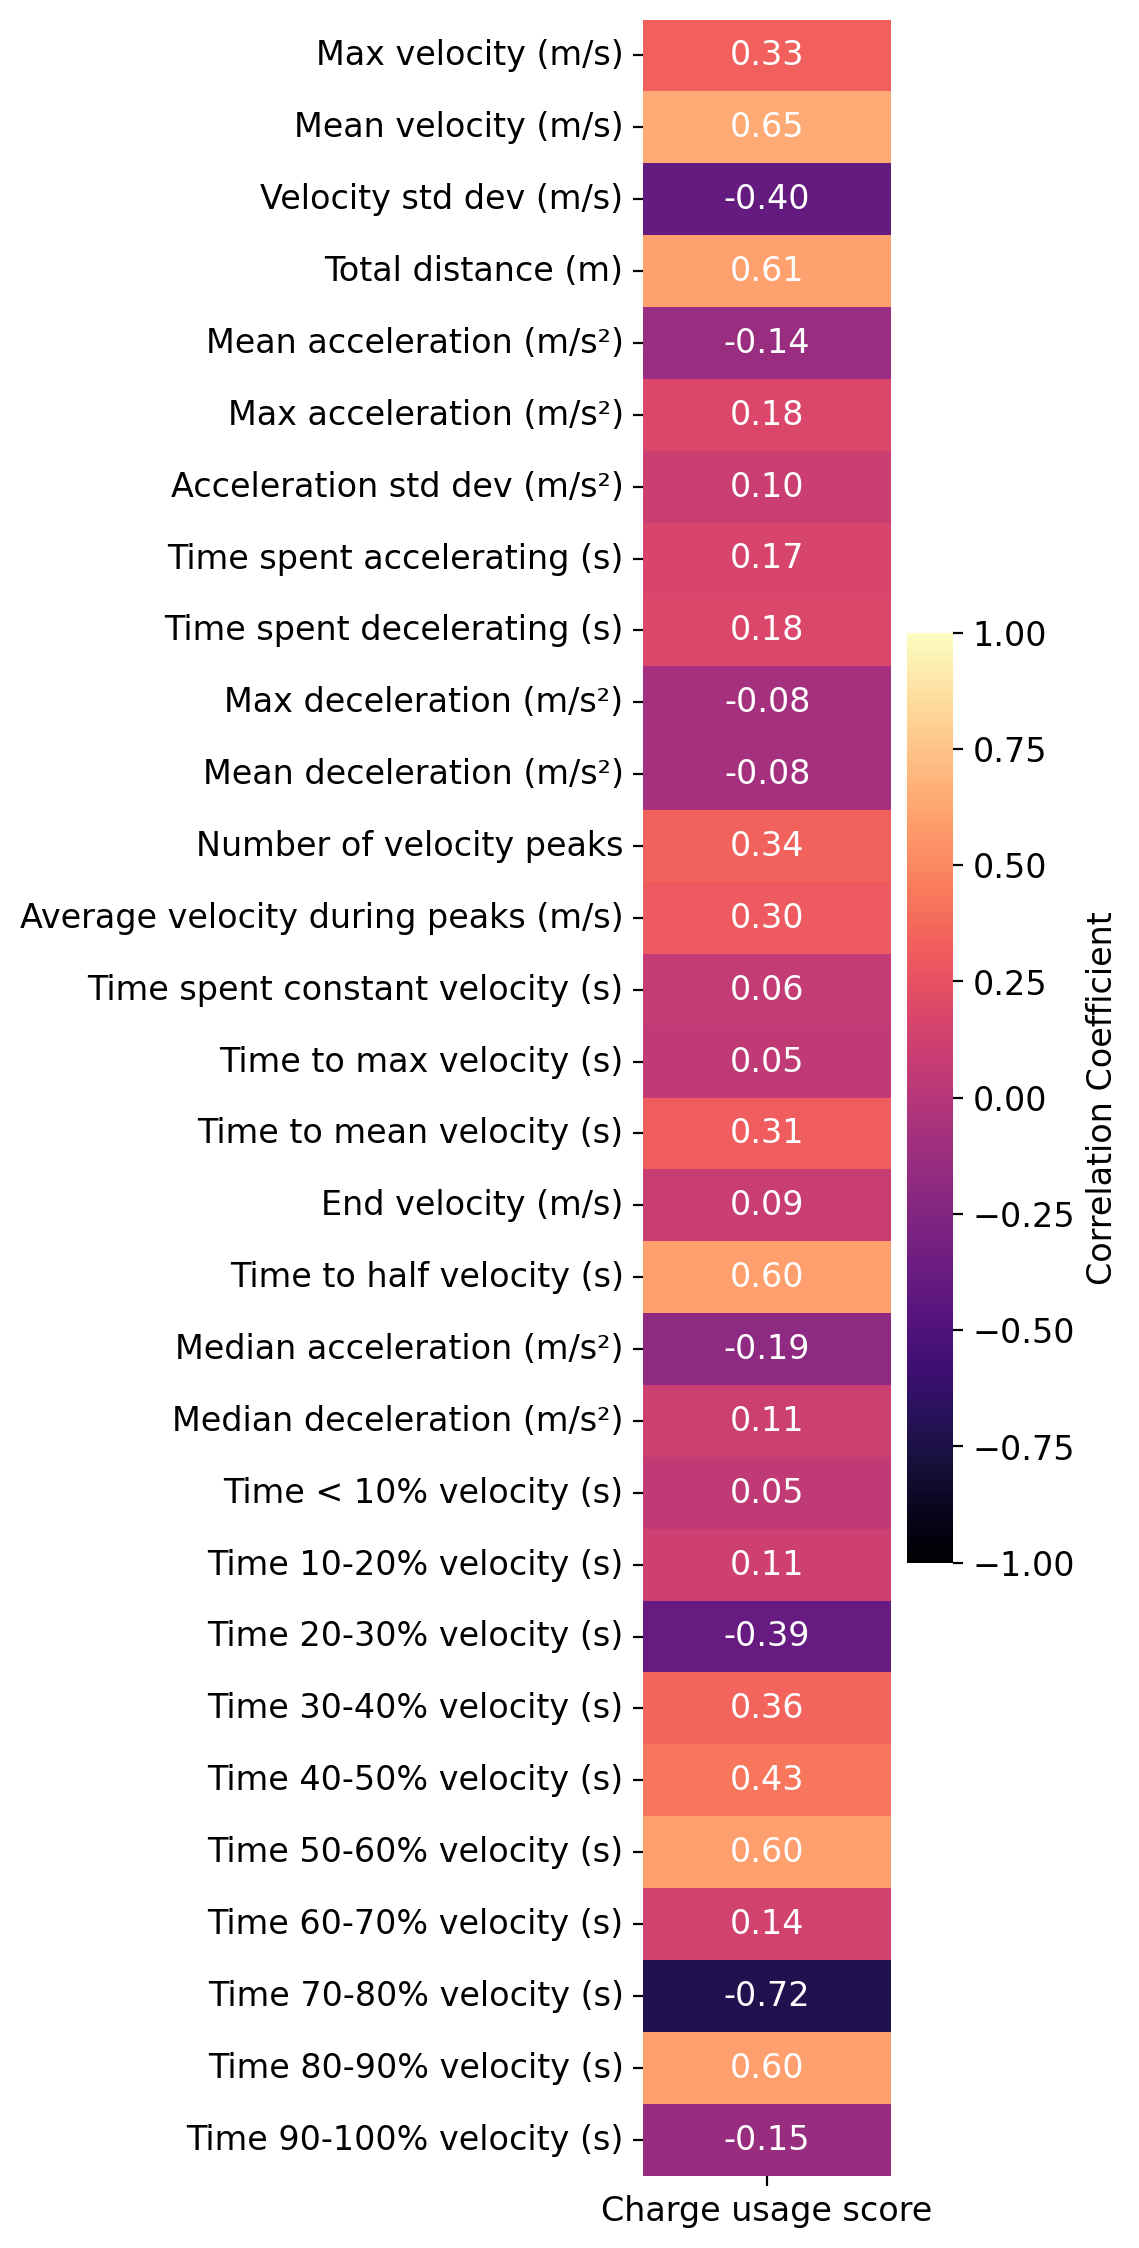

In [32]:
sns.reset_orig()
plt.rcdefaults()
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (2, 14)
corr_matrix = vel_info.corr()
target_corr = corr_matrix[['Relative_SOC_drop (%)']].drop(['Relative_SOC_drop (%)'], axis=0)

rename_dict = {
    'Max velocity (m/s)': 'Max velocity (m/s)',
    'Mean velocity (m/s)': 'Mean velocity (m/s)',
    'Velocity Std Dev (m/s)': 'Velocity std dev (m/s)',
    'Total Distance (m)': 'Total distance (m)',
    'Mean Acceleration (m/s^2)': 'Mean acceleration (m/s²)',
    'Max Acceleration (m/s^2)': 'Max acceleration (m/s²)',
    'Acceleration Std Dev (m/s^2)': 'Acceleration std dev (m/s²)',
    'Time Spent Accelerating (s)': 'Time spent accelerating (s)',
    'Time Spent Decelerating (s)': 'Time spent decelerating (s)',
    'Max Deceleration (m/s^2)': 'Max deceleration (m/s²)',
    'Mean Deceleration (m/s^2)': 'Mean deceleration (m/s²)',
    'Number of velocity Peaks': 'Number of velocity peaks',
    'Average velocity During Peaks (m/s)': 'Average velocity during peaks (m/s)',
    'Time Spent Constant Velocity(s)': 'Time spent constant velocity (s)',
    'Time_to_max_velocity (s)': 'Time to max velocity (s)',
    'Time_to_mean_velocity (s)': 'Time to mean velocity (s)',
    'End Velocity (m/s)': 'End velocity (m/s)',
    'Time_to_half_velocity (s)': 'Time to half velocity (s)',
    'Median_acceleration (m/s^2)': 'Median acceleration (m/s²)',
    'Median_deceleration (m/s^2)': 'Median deceleration (m/s²)',
    'Time < 10% velocity (s)': 'Time < 10% velocity (s)',
    'Time 10-20% velocity (s)': 'Time 10-20% velocity (s)',
    'Time 20-30% velocity (s)': 'Time 20-30% velocity (s)',
    'Time 30-40% velocity (s)': 'Time 30-40% velocity (s)',
    'Time 40-50% velocity (s)': 'Time 40-50% velocity (s)',
    'Time 50-60% velocity (s)': 'Time 50-60% velocity (s)',
    'Time 60-70% velocity (s)': 'Time 60-70% velocity (s)',
    'Time 70-80% velocity (s)': 'Time 70-80% velocity (s)',
    'Time 80-90% velocity (s)': 'Time 80-90% velocity (s)',
    'Time 90-100% velocity (s)': 'Time 90-100% velocity (s)',
    'Relative_SOC_drop (%)': 'Charge usage score (%)'
}

fig, ax = plt.subplots()
target_corr.columns = ['Charge usage score']
target_corr.index = target_corr.index.to_series().replace(rename_dict)

sns.heatmap(target_corr, annot=True, fmt=".2f", cmap='magma', vmin=-1, vmax=1, annot_kws={"color": "white"}, cbar_kws={"label": "Correlation Coefficient"}, cbar = True)
# plt.title('Pearson Correlation Heatmap Between Features and Relative_SOC_Drop (%)')
# fig.savefig(PLOT_DIR / 'correlation_velocity_model1.svg', format='svg', dpi=2000, bbox_inches='tight')
plt.show()

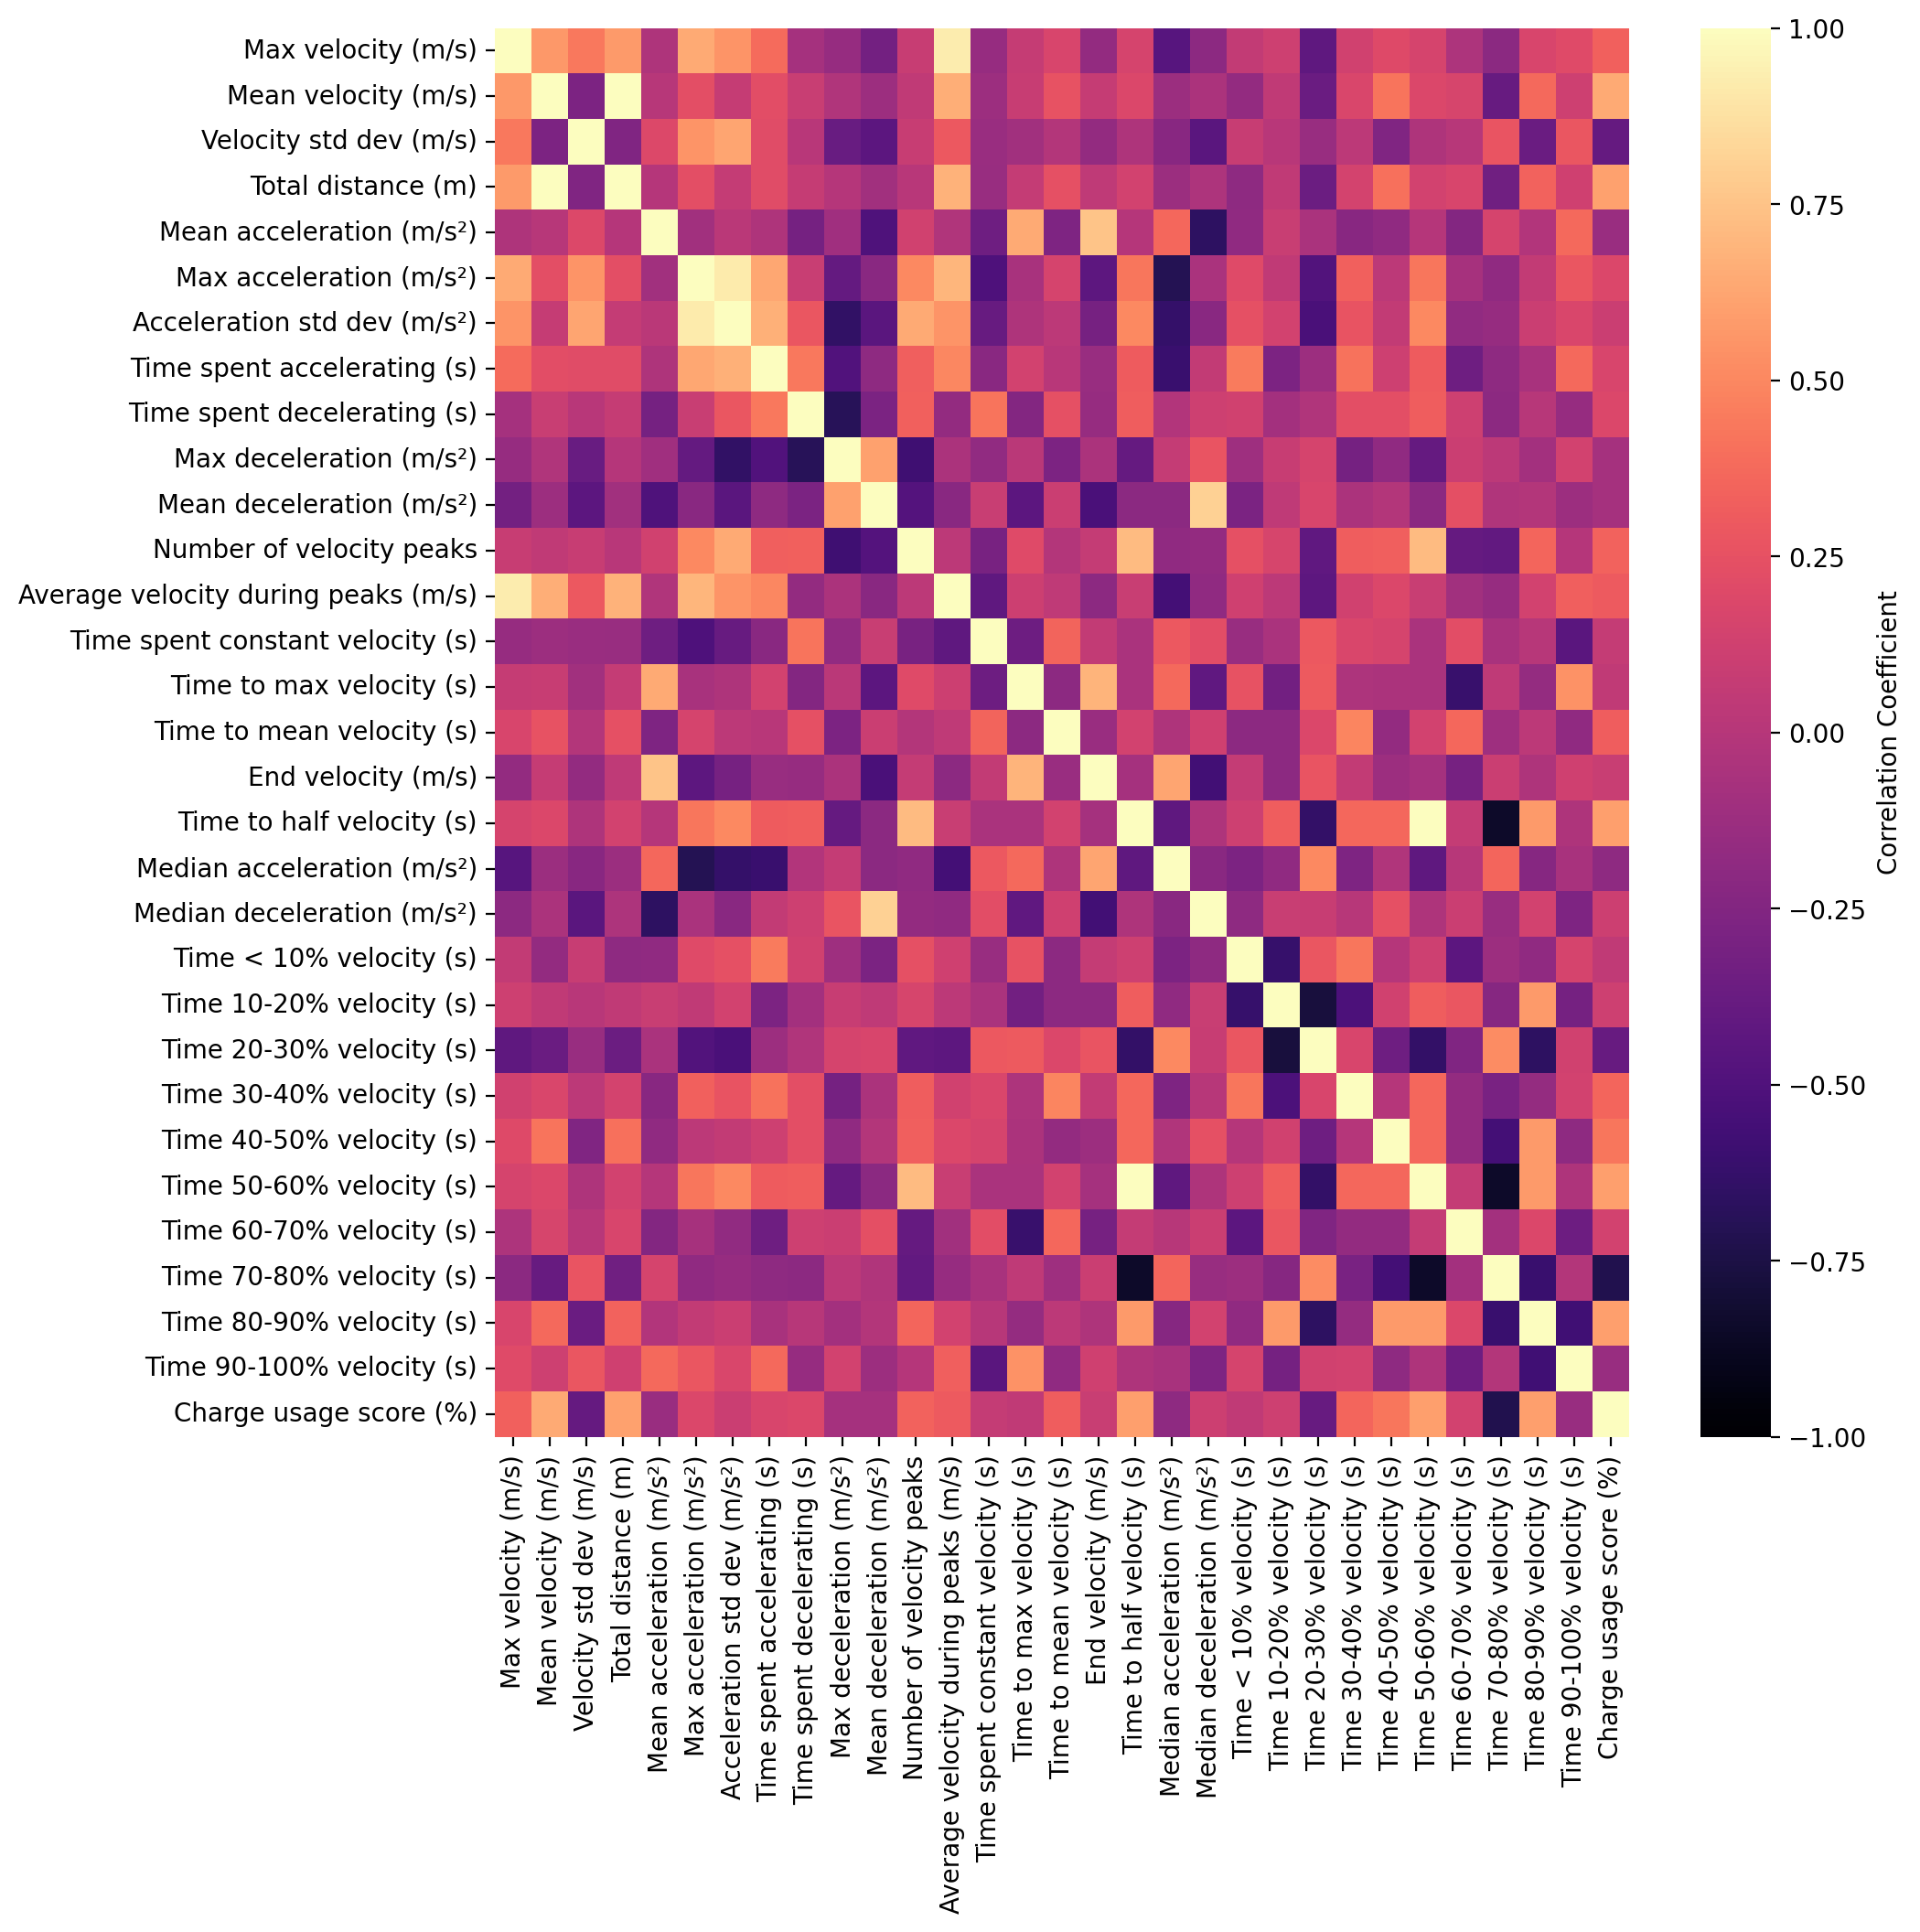

In [42]:
sns.reset_defaults()
plt.rcdefaults()
corr_matrix_renamed = corr_matrix.copy()

corr_matrix_renamed.index = corr_matrix_renamed.index.to_series().replace(rename_dict)
corr_matrix_renamed.columns = corr_matrix_renamed.columns.to_series().replace(rename_dict)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix_renamed, fmt=".2f", cmap='magma', vmin=-1, vmax=1,
            annot_kws={"color": "white"}, cbar_kws={"label": "Correlation Coefficient"}, cbar=True)

# plt.title('Pearson Correlation Heatmap Between Features and Charge Usage Score (%)')
# fig.savefig(PLOT_DIR / 'full_correlation_velocity_model1.svg', format='svg', dpi=2000, bbox_inches='tight')
plt.show()

In [31]:
# Initialize an empty list to store feature dictionaries for the test dataset
all_features_test = []

# Loop through the dictionary of DataFrames (test dataset) and extract features for each one
for key in cut_dict_test:
    timeseries = cut_dict_test[key]
    features = featurize_velocity(timeseries)
    features['Mini_trip'] = key  # Add Mini_trip information
    all_features_test.append(features)

# Convert the list of feature dictionaries to a DataFrame
vel_info_test = pd.DataFrame(all_features_test)

# Add the 'Relative_SOC_drop (%)' from test_df to complete the dataset with all extracted features
vel_info_test['Relative_SOC_drop (%)'] = test_df['Relative_SOC_drop (%)']

# Rename columns with corresponding unit in a formal format
vel_info_test.rename(columns={
    'max_velocity': 'Max velocity (m/s)',
    'mean_velocity': 'Mean velocity (m/s)',
    'std_velocity': 'Velocity Std Dev (m/s)',
    'total_distance': 'Total Distance (m)',
    'mean_acceleration': 'Mean Acceleration (m/s^2)',
    'max_acceleration': 'Max Acceleration (m/s^2)',
    'std_acceleration': 'Acceleration Std Dev (m/s^2)',
    'time_spent_accelerating': 'Time Spent Accelerating (s)',
    'time_spent_decelerating': 'Time Spent Decelerating (s)',
    'max_deceleration': 'Max Deceleration (m/s^2)',
    'mean_deceleration': 'Mean Deceleration (m/s^2)',
    'number_of_velocity_peaks': 'Number of velocity Peaks',
    'average_velocity_during_peaks': 'Average velocity During Peaks (m/s)',
    'time_spent_constant_velocity': 'Time Spent Constant Velocity(s)',

    # Time-series features
    'time10': 'Time < 10% velocity (s)',
    'time10_20': 'Time 10-20% velocity (s)',
    'time20_30': 'Time 20-30% velocity (s)',
    'time30_40': 'Time 30-40% velocity (s)',
    'time40_50': 'Time 40-50% velocity (s)',
    'time50_60': 'Time 50-60% velocity (s)',
    'time60_70': 'Time 60-70% velocity (s)',
    'time70_80': 'Time 70-80% velocity (s)',
    'time80_90': 'Time 80-90% velocity (s)',
    'time90_100': 'Time 90-100% velocity (s)',

    # Time-dependent features
    'time_to_max_velocity': 'Time_to_max_velocity (s)',
    'time_to_half_velocity': 'Time_to_half_velocity (s)',
    'time_to_mean_velocity': 'Time_to_mean_velocity (s)',
    'end_velocity': 'End Velocity (m/s)',
    'median_acceleration': 'Median_acceleration (m/s^2)',
    'median_deceleration': 'Median_deceleration (m/s^2)',
    
}, inplace=True)

# Set the 'Mini_trip' as the index for convenience to track each feature of each drive cycle
vel_info_test.set_index('Mini_trip', inplace=True)

# Display the DataFrame for visual checking
vel_info_test


/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_distance = np.trapz(timeseries["speed"], timeseries["time"])
/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_distance = np.trapz(timeseries["speed"], timeseries["time"])
/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_distance = np.trapz(timeseries["speed"], timeseries["time"])
/var/folders/20/47db4tl16cs85c5h4w_qwyt00000gn/T/ipykernel_961/1344607779.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` in

,Max velocity (m/s),Mean velocity (m/s),Velocity Std Dev (m/s),Total Distance (m),Mean Acceleration (m/s^2),Max Acceleration (m/s^2),Acceleration Std Dev (m/s^2),Time Spent Accelerating (s),Time Spent Decelerating (s),Max Deceleration (m/s^2),...,Time 10-20% velocity (s),Time 20-30% velocity (s),Time 30-40% velocity (s),Time 40-50% velocity (s),Time 50-60% velocity (s),Time 60-70% velocity (s),Time 70-80% velocity (s),Time 80-90% velocity (s),Time 90-100% velocity (s),Relative_SOC_drop (%)
Mini_trip,,,,,,,,,,,,,,,,,,,,,
1,25.518707,23.847737,0.999660,11380.154102,0.000071,0.055556,0.040329,0.000000,0.000000,-0.154938,...,55.102041,36.734694,55.102041,55.102041,36.734694,36.734694,36.734694,55.102041,55.102041,83.011496
2,25.374150,23.222902,1.145177,10942.301819,0.003334,0.184606,0.053014,0.000000,0.000000,-0.093895,...,39.183673,58.775510,39.183673,58.775510,39.183673,39.183673,58.775510,39.183673,58.775510,76.977501
3,25.518707,23.847737,0.999660,11380.154102,0.000071,0.055556,0.040329,0.000000,0.000000,-0.154938,...,55.102041,36.734694,55.102041,55.102041,36.734694,36.734694,36.734694,55.102041,55.102041,76.112164
4,25.374150,23.222902,1.145177,10942.301819,0.003334,0.184606,0.053014,0.000000,0.000000,-0.093895,...,39.183673,58.775510,39.183673,58.775510,39.183673,39.183673,58.775510,39.183673,58.775510,71.774646
5,25.518707,23.847737,0.999660,11380.154102,0.000071,0.055556,0.040329,0.000000,0.000000,-0.154938,...,55.102041,36.734694,55.102041,55.102041,36.734694,36.734694,36.734694,55.102041,55.102041,83.200715
6,25.374150,23.222902,1.145177,10942.301819,0.003334,0.184606,0.053014,0.000000,0.000000,-0.093895,...,39.183673,58.775510,39.183673,58.775510,39.183673,39.183673,58.775510,39.183673,58.775510,77.160583
7,26.077098,23.668010,1.078894,11302.426072,0.001674,0.106790,0.035790,0.000000,0.000000,-0.074074,...,55.102041,36.734694,36.734694,55.102041,36.734694,55.102041,36.734694,55.102041,55.102041,72.951019
8,30.753968,24.355501,3.445918,11727.891156,0.004464,0.268519,0.106349,34.285714,17.142857,-0.171296,...,34.285714,51.428571,51.428571,51.428571,34.285714,51.428571,51.428571,51.428571,51.428571,83.197004
9,26.077098,23.668010,1.078894,11302.426072,0.001674,0.106790,0.035790,0.000000,0.000000,-0.074074,...,55.102041,36.734694,36.734694,55.102041,36.734694,55.102041,36.734694,55.102041,55.102041,68.645862


In [ ]:
# # Compute the Pearson correlation matrix and set the 'Relative_SOC_drop (%)' as the target variable
# corr_matrix = vel_info_test.corr()

# # Select the correlations with 'Relative_SOC_drop (%)'
# target_corr = corr_matrix[['Relative_SOC_drop (%)']].drop(['Relative_SOC_drop (%)'], axis=0)

# # Plot the heatmap for the target variable correlations
# plt.figure(figsize=(14, 16))
# sns.heatmap(target_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap Between Features and Relative_SOC_Drop (%)')
# plt.show()


In [43]:
## Regression ML models
def linear_regression(df1, df2):
    X_1 = df1.drop(columns=['Relative_SOC_drop (%)'])
    y_1 = df1['Relative_SOC_drop (%)']
    X_2_test = df2.drop(columns=['Relative_SOC_drop (%)'])
    y_2_test = df2['Relative_SOC_drop (%)']

    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    scaler = StandardScaler()
    X_1_train_scaled = scaler.fit_transform(X_1_train)
    X_1_test_scaled = scaler.transform(X_1_test)
    X_2_test_scaled = scaler.transform(X_2_test)

    linear_model = LinearRegression()
    linear_model.fit(X_1_train_scaled, y_1_train)
    y_pred_test = linear_model.predict(X_2_test_scaled)
    mape_linear = mean_absolute_percentage_error(y_2_test, y_pred_test)
    
    return linear_model, mape_linear

def knn_regression(df1, df2):
    X_1 = df1.drop(columns=['Relative_SOC_drop (%)'])
    y_1 = df1['Relative_SOC_drop (%)']
    X_2_test = df2.drop(columns=['Relative_SOC_drop (%)'])
    y_2_test = df2['Relative_SOC_drop (%)']

    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    scaler = StandardScaler()
    X_1_train_scaled = scaler.fit_transform(X_1_train)
    X_1_test_scaled = scaler.transform(X_1_test)
    X_2_test_scaled = scaler.transform(X_2_test)

    param_grid = {'n_neighbors': range(1, 10), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
    grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_1_train_scaled, y_1_train)
    knn_model = grid_search.best_estimator_
    knn_model.fit(X_1_train_scaled, y_1_train)
    y_pred_test = knn_model.predict(X_2_test_scaled)  
    mape_knn = mean_absolute_percentage_error(y_2_test, y_pred_test)
    
    return knn_model, mape_knn

def decision_tree_regression(df1, df2):
    X_1 = df1.drop(columns=['Relative_SOC_drop (%)'])
    y_1 = df1['Relative_SOC_drop (%)']
    X_2_test = df2.drop(columns=['Relative_SOC_drop (%)'])
    y_2_test = df2['Relative_SOC_drop (%)']

    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    scaler = StandardScaler()
    X_1_train_scaled = scaler.fit_transform(X_1_train)
    X_1_test_scaled = scaler.transform(X_1_test)
    X_2_test_scaled = scaler.transform(X_2_test)

    param_grid = {'max_depth': [None, 10, 20, 50], 'min_samples_split': [2, 5, 10]}
    grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_1_train_scaled, y_1_train)
    decision_tree_model = grid_search.best_estimator_
    decision_tree_model.fit(X_1_train_scaled, y_1_train)
    y_pred_test = decision_tree_model.predict(X_2_test_scaled)
    mape_dt = mean_absolute_percentage_error(y_2_test, y_pred_test)

    return decision_tree_model, mape_dt

def random_forest_regression(df1, df2):
    X_1 = df1.drop(columns=['Relative_SOC_drop (%)'])
    y_1 = df1['Relative_SOC_drop (%)']
    X_2_test = df2.drop(columns=['Relative_SOC_drop (%)'])
    y_2_test = df2['Relative_SOC_drop (%)']

    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    scaler = StandardScaler()
    X_1_train_scaled = scaler.fit_transform(X_1_train)
    X_1_test_scaled = scaler.transform(X_1_test)
    X_2_test_scaled = scaler.transform(X_2_test)


    param_grid = {'n_estimators': [550, 600, 650], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_1_train_scaled, y_1_train)
    rf_model = grid_search.best_estimator_
    rf_model.fit(X_1_train_scaled, y_1_train)

    y_pred_train = rf_model.predict(X_1_train)
    y_pred_val = rf_model.predict(X_1_test)
    y_pred_test = rf_model.predict(X_2_test_scaled)

    mae_rf = mean_absolute_error(y_2_test, y_pred_test)
    mape_rf = mean_absolute_percentage_error(y_2_test, y_pred_test)
    
    return rf_model, mape_rf, y_pred_train, y_1_train, y_pred_val, y_1_test, y_pred_test, y_2_test


def gaussian_process_regression(df1, df2):
    X_1 = df1.drop(columns=['Relative_SOC_drop (%)'])
    y_1 = df1['Relative_SOC_drop (%)']
    X_2_test = df2.drop(columns=['Relative_SOC_drop (%)'])
    y_2_test = df2['Relative_SOC_drop (%)']

    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    scaler = StandardScaler()
    X_1_train_scaled = scaler.fit_transform(X_1_train)
    X_1_test_scaled = scaler.transform(X_1_test)
    X_2_test_scaled = scaler.transform(X_2_test)

    param_grid = {
        'alpha': [1e-4, 1e-3, 1e-2, 0.1, 1],
        'kernel': [
            RBF(length_scale=1.0), 
            Matern(length_scale=1.0, nu=1.5), 
            Matern(length_scale=2.0, nu=0.5)
        ],
        'normalize_y': [True, False]
    }
    gpr = GaussianProcessRegressor()
    grid_search = GridSearchCV(gpr, param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_1_train_scaled, y_1_train)
    gp_model = grid_search.best_estimator_
    gp_model.fit(X_1_train_scaled, y_1_train)
    y_pred_test = gp_model.predict(X_2_test_scaled)
    mape_gp = mean_absolute_percentage_error(y_2_test, y_pred_test)
    
    return gp_model, mape_gp

def extra_trees_regression(df1, df2):
    X_1 = df1.drop(columns=['Relative_SOC_drop (%)'])
    y_1 = df1['Relative_SOC_drop (%)']
    X_2_test = df2.drop(columns=['Relative_SOC_drop (%)'])
    y_2_test = df2['Relative_SOC_drop (%)']

    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    scaler = StandardScaler()
    X_1_train_scaled = scaler.fit_transform(X_1_train)
    X_1_test_scaled = scaler.transform(X_1_test)
    X_2_test_scaled = scaler.transform(X_2_test)

    param_grid = {'n_estimators': [400, 500, 600], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
    grid_search = GridSearchCV(ExtraTreesRegressor(), param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_1_train_scaled, y_1_train)
    extra_trees_model = grid_search.best_estimator_
    extra_trees_model.fit(X_1_train_scaled, y_1_train)
    y_pred_test = extra_trees_model.predict(X_2_test_scaled)
    mape_et = mean_absolute_percentage_error(y_2_test, y_pred_test)
    
    return extra_trees_model, mape_et

In [44]:
# Selected features
df_selected = vel_info[[ 
                        # Selected features from the Pearson correlation heatmap
                        'Total Distance (m)' , #-0.61
                        'Velocity Std Dev (m/s)', # 0.4 
                        'Time_to_half_velocity (s)', #-0.6
                        'Time_to_mean_velocity (s)', #-0.31
                        
                        # Target variable
                        'Relative_SOC_drop (%)']]

# Selected features
df_test_selected = vel_info_test[[ 
                        # Selected features from the Pearson correlation heatmap
                        'Total Distance (m)' , #-0.61
                        'Velocity Std Dev (m/s)', # 0.4 
                        'Time_to_half_velocity (s)', #-0.6
                        'Time_to_mean_velocity (s)', #-0.31
                        
                        # Target variable
                        'Relative_SOC_drop (%)']]

In [45]:
# Function to run the models multiple times and calculate the average and std of MAPE
def evaluate_models(df1, df2, iterations):
    results = {
        'Linear': [],
        'KNN': [],
        'Decision Tree': [],
        'Random Forest': [],
        'Gaussian Process': [],
        'Extremely Randomized Trees': []
    }
    
    for _ in range(iterations):
        _, mape_linear = linear_regression(df1, df2)
        _, mape_knn = knn_regression(df1, df2)
        _, mape_dt = decision_tree_regression(df1, df2)
        _, mape_rf, y_pred_train, y_1_train, y_pred_val, y_1_test, y_pred_test, y_2_test = random_forest_regression(df1, df2)
        _, mape_gp = gaussian_process_regression(df1, df2)
        _, mape_et = extra_trees_regression(df1, df2)
        
        results['Linear'].append(mape_linear)
        results['KNN'].append(mape_knn)
        results['Decision Tree'].append(mape_dt)
        results['Random Forest'].append(mape_rf)
        results['Gaussian Process'].append(mape_gp)
        results['Extremely Randomized Trees'].append(mape_et)
    
    avg_results = {model: np.mean(mapes) for model, mapes in results.items()}
    std_results = {model: np.std(mapes) for model, mapes in results.items()}
    
    return avg_results, std_results, y_pred_train, y_1_train, y_pred_val, y_1_test, y_pred_test, y_2_test

/Users/hemanthnr/Library/Caches/pypoetry/virtualenvs/ev-range-anxiety-RrTLfGNy-py3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/hemanthnr/Library/Caches/pypoetry/virtualenvs/ev-range-anxiety-RrTLfGNy-py3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/hemanthnr/Library/Caches/pypoetry/virtualenvs/ev-range-anxiety-RrTLfGNy-py3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/hemanthnr/Library/Caches/pypoetry/virtualenvs/ev-range-anxiety-RrTLfGNy-py3.11/lib/python3.11/site-pack

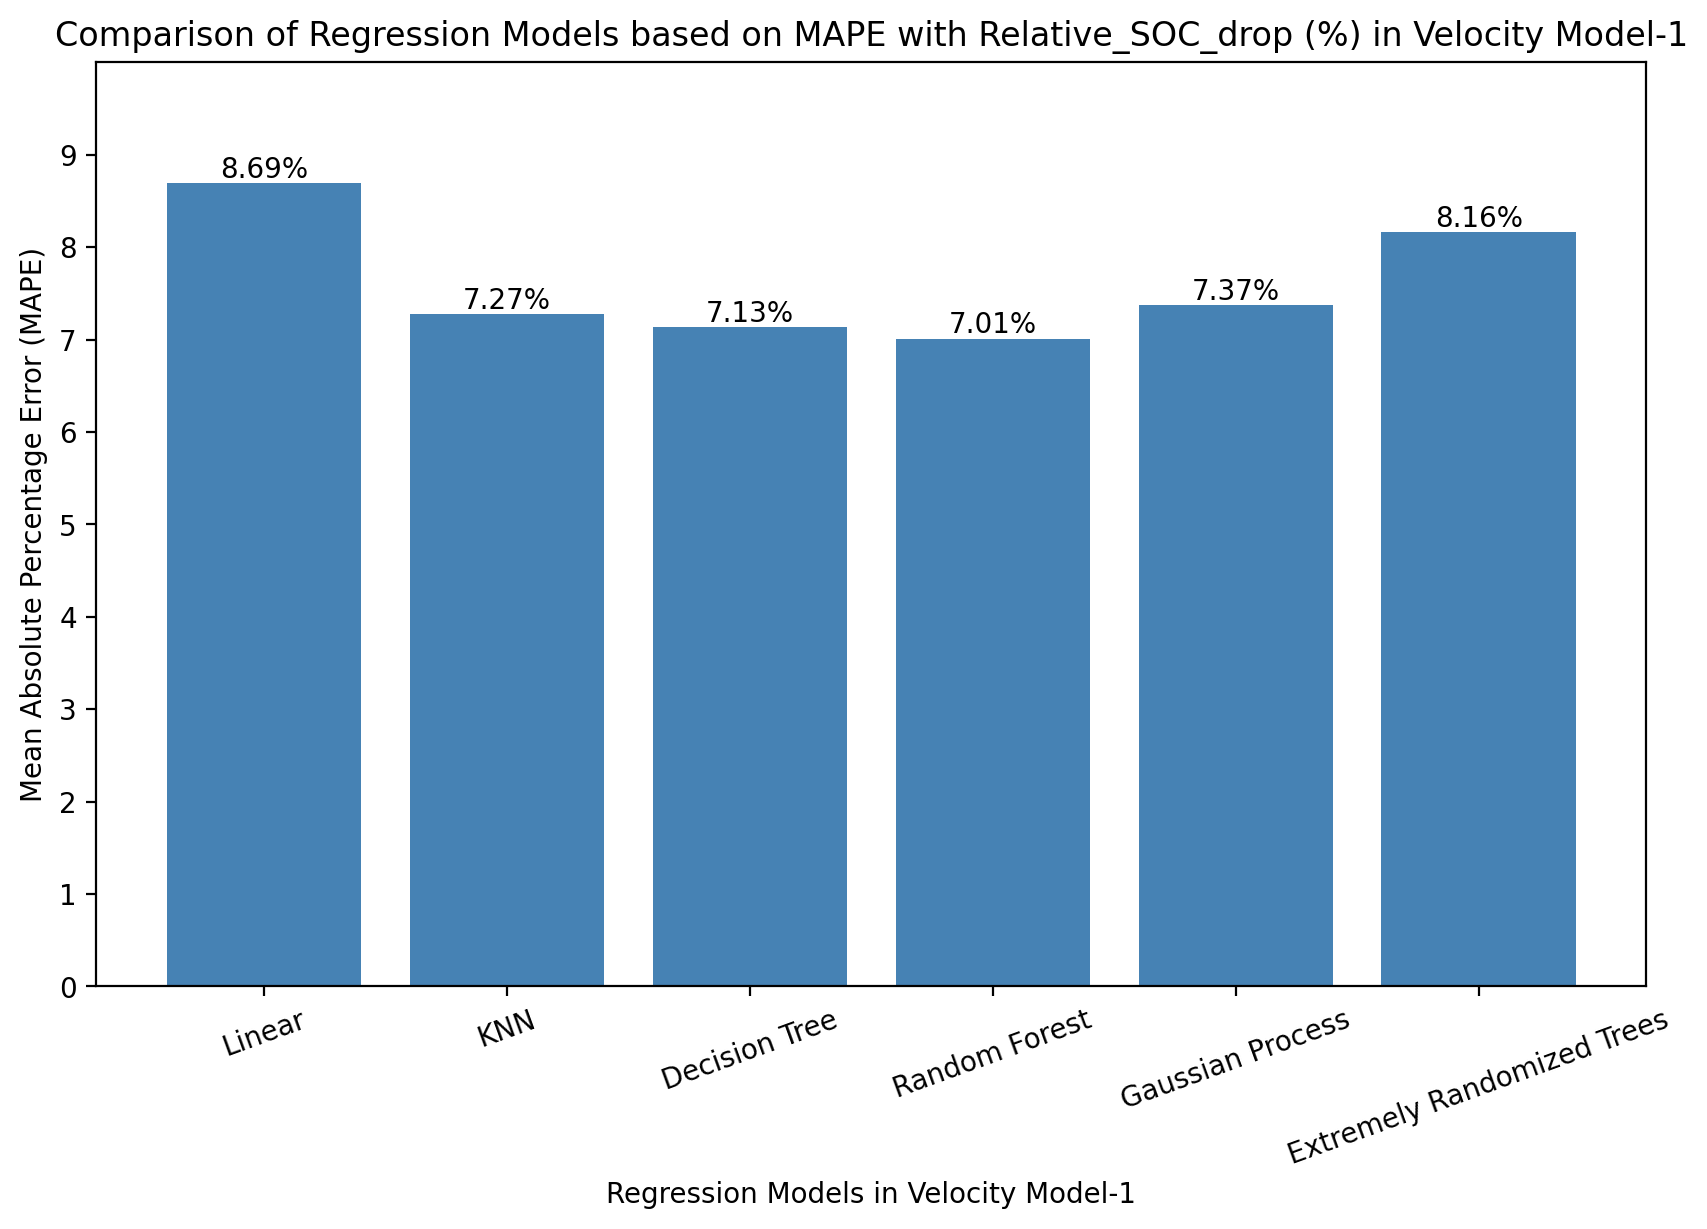

In [54]:
avg_results, std_results, y_pred_train, y_1_train, y_pred_val, y_1_test, y_pred_test, y_2_test = evaluate_models(df_selected, df_test_selected, iterations=10)

# Plot the results
models = list(avg_results.keys())
avg_mape_values = [avg_results[model] * 100 for model in models]
std_mape_values = [std_results[model] * 100 for model in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, avg_mape_values, capsize=5, color='steelblue')

for bar, mape in zip(bars, avg_mape_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{mape:.2f}%', ha='center', va='bottom')

plt.xlabel('Regression Models in Velocity Model-1')
plt.xticks(rotation=20)
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.title('Comparison of Regression Models based on MAPE with Relative_SOC_drop (%) in Velocity Model-1')

# Set y-axis limits and ticks
plt.ylim(0, 10)
plt.yticks(np.arange(0, 10, 1))

plt.show()

In [53]:
np.savez(MISC_DIR/'velocity_model_1_results(all_models).npz', y_pred_train, y_1_train, y_pred_val, y_1_test, y_pred_test, y_2_test)